In [240]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
import os
from time import time
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

In [540]:
df_model = pd.read_pickle('../data/final/NotIot_clean_FR_news_lexic.p')

In [541]:
df_model

,count_words,count_capital_words,count_excl_quest_marks,sentiment,origin_text,clean_text,lex_anger,lex_sadness,lex_joy,lex_fear,lex_surprise,lex_disgust,lex_neutre
0,12,0,0,joie,Un test pour prédire la rechute du cancer du sein est approuvé,test prédire rechute cancer sein approuvé,0.166667,0.333333,0.000000,0.333333,0.166667,0.166667,0.000000
1,11,0,0,tristesse,"Un allié de Saddam Hussein est pendu, selon un responsable irakien",allié saddam hussein pendu selon responsable irakien,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5,1,0,joie,Vues et sons du CES,vues sons,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000
3,7,0,0,joie,Schuey voit Ferrari dévoiler une nouvelle voiture,schuey voit ferrari dévoiler nouvelle voiture,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000
4,15,0,0,peur,Les clôtures et les annulations sont les meilleurs conseils en cas d’épidémie de grippe,clôtures annulations meilleurs conseils cas d’épidémie grippe,0.111111,0.222222,0.000000,0.222222,0.111111,0.111111,0.000000
5,7,0,0,tristesse,Camions avalés dans l'effondrement du métro,camions avalés effondrement métro,0.000000,0.250000,0.000000,0.250000,0.250000,0.250000,0.000000
6,12,0,0,surprise,Une lettre de Sarkozy surprend l'audience sur les dessins animés français,lettre sarkozy surprend audience dessins animés français,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000
7,11,0,0,tristesse,"Construire un monument à un fils, un enfant à la fois",construire monument fils enfant fois,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
8,14,0,0,surprise,Un législateur veut interdire les iPod dans les passages pour piétons à New York,législateur veut interdire ipod passages piétons new york,0.125000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000
9,7,0,0,tristesse,Diabetic attend des lunettes pendant des mois,diabetic attend lunettes pendant mois,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [542]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('sentiment', axis=1), df_model.sentiment, test_size=0.1, random_state=37)

In [543]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [544]:
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None):
    
   
    textcountscols = ['count_capital_words','count_emojis'
                      ,'count_excl_quest_marks','count_hashtags','count_mentions','count_urls',
                      'count_words']
    
    lexiccols = ['lex_anger','lex_sadness','lex_joy','lex_fear','lex_surprise','lex_disgust','lex_neutre']
    

    features = FeatureUnion([# ('textcounts', ColumnExtractor(cols=textcountscols)),
                            #('lexiccols', ColumnExtractor(cols=lexiccols)),
                        ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                            , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # initiate gridsearchCV with parameters and pipline
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))

    print("all results")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    return grid_search

In [545]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}
# Parameter grid settings for LogisticRegression
parameters_lg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

In [546]:
lg = LogisticRegression()

In [547]:
countvect = CountVectorizer()

In [548]:
# LogisticRegression
best_lg_countvect = grid_vect(lg, parameters_lg, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   49.1s finished


done in 49.634s

Best CV score: 0.477
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.455


Classification Report Test Data
              precision    recall  f1-score   support

      colère       0.00      0.00      0.00         7
    dégoûter       0.00      0.00      0.00         1
        joie       0.50      0.81      0.62        43
        peur       0.36      0.29      0.32        17
    surprise       0.50      0.10      0.17        20
   tristesse       0.27      0.27      0.27        11

   micro avg       0.45      0.45      0.45        99
   macro avg       0.27      0.25      0.23        99
weighted avg       0.41      0.45      0.39        99

all results
0.367531 (0.007704) with: {'clf__C': 0.25, 'clf__penalty': 'l1', 'features__pipe__vect__max_df': 0.25, 'features__pipe__vect__min_df': 1, 'features__pipe__vect__ngram_r

In [549]:
tfidfvect = TfidfVectorizer()

In [550]:
best_lg_tfidf = grid_vect(lg, parameters_lg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__C': (0.25, 0.5, 1.0),
 'clf__penalty': ('l1', 'l2'),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   43.8s finished


done in 44.238s

Best CV score: 0.448
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.475


Classification Report Test Data
              precision    recall  f1-score   support

      colère       0.00      0.00      0.00         7
    dégoûter       0.00      0.00      0.00         1
        joie       0.50      0.84      0.63        43
        peur       0.42      0.29      0.34        17
    surprise       0.33      0.05      0.09        20
   tristesse       0.42      0.45      0.43        11

   micro avg       0.47      0.47      0.47        99
   macro avg       0.28      0.27      0.25        99
weighted avg       0.40      0.47      0.40        99

all results
0.356257 (0.002061) with: {'clf__C': 0.25, 'clf__penalty': 'l1', 'features__pipe__vect__max_df': 0.25, 'features__pipe__vect__min_df': 1, 'features__pipe__vect__ngram_r

In [551]:
df_model_pos = pd.read_pickle('../data/final/sondage_emotion_clean.p')
df_model_pos.dropna(how='any', inplace=True)
df_model_pos=df_model_pos.loc[(df_model_pos.clean_text.notnull()) & (df_model_pos.sentiment.notnull())]

df_model_pos['sentiment'][df_model_pos['sentiment']=='MEPRIS']='dégoûter'
df_model_pos['sentiment'][df_model_pos['sentiment']=='COLERE']='colère'
df_model_pos['sentiment'][df_model_pos['sentiment']=='ENNUI']='dégoûter'
df_model_pos['sentiment'][df_model_pos['sentiment']=='PEUR']='peur'
df_model_pos['sentiment'][df_model_pos['sentiment']=='AMOUR']='joie'
df_model_pos['sentiment'][df_model_pos['sentiment']=='APAISEMENT']='joie'
df_model_pos['sentiment'][df_model_pos['sentiment']=='PLAISIR']='joie'
df_model_pos['sentiment'][df_model_pos['sentiment']=='SURPRISE']='surprise'

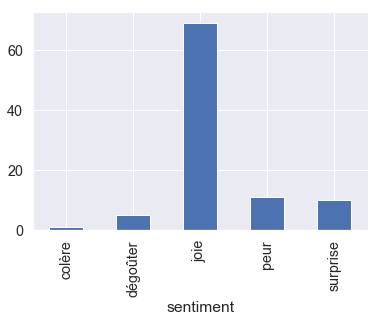

In [554]:

df_model_pos['clean_text'].groupby([df_model_pos.sentiment]).count().plot(kind='bar')


In [555]:
#max_df: 0.25 or maximum document frequency of 25%.
#min_df: 2 or the words need to appear in at least 2 tweets
#ngram_range: (1, 2), both single words as bi-grams are used
#clf__C: 1
#clf__penalty: l2
textcountscols = ['count_capital_words','count_emojis',
                  'count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls',
                  'count_words']
    
features = FeatureUnion([#('textcounts', ColumnExtractor(cols=textcountscols)),
                         ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text'))
                                              , ('vect',TfidfVectorizer(max_df=0.25, min_df=2, ngram_range=(1,1)))]))]
                       , n_jobs=-1)

pipeline = Pipeline([
    ('features', features)
    , ('clf', LogisticRegression(C=1, penalty='l2'))
])

best_model = pipeline.fit(df_model.drop('sentiment', axis=1), df_model.sentiment)

In [556]:
y_pred= best_model.predict(df_model_pos.drop('sentiment', axis=1)).tolist()
len(y_pred)

96

In [557]:
y_true = df_model_pos['sentiment']
#y_true

In [558]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      colère       0.00      0.00      0.00         1
    dégoûter       0.00      0.00      0.00         5
        joie       0.72      0.70      0.71        69
        peur       0.00      0.00      0.00        11
    surprise       0.10      0.20      0.13        10
   tristesse       0.00      0.00      0.00         0

   micro avg       0.52      0.52      0.52        96
   macro avg       0.14      0.15      0.14        96
weighted avg       0.53      0.52      0.52        96



In [559]:
misclassified = np.where(y_true != best_model.predict(df_model_pos.drop('sentiment', axis=1)))

In [560]:

for i in misclassified: 
    print(list(df_model_pos['clean_text'][i]))
    print(i)

['abord sentiment curiosité étude evaluer si capteurs utiles non', 'ils présents ne gênent pas plus ça ne peux rien faire donc bon', nan, nan, nan, nan, nan, 'mesure base analyse acv système plus performant vois avantage cependant systèmes intelligents risquent part rendre plus dépendant utilisateurs comportement moins intelligent', nan, 'l’internet objets réconcilie monde numérique virtuel crée réseaux informatique applications mobiles monde physique', nan, 'iot permettra adopter comportement plus écocitoyen peu compétition campus plus vert', nan, nan, nan, nan, 'personnes situations handicaps bien', nan, nan, 'général surprise utilisation composants parfois sens trop satisfaite psq intelligent ça facilite existence parfois sens abusé', 'c’est bien faciliter vie gens', 'ça rend toujour heureux voir l’impact positif l’avancement technologique vie', nan, nan, 'utilisation iot campus universitaires pourrait grandement augmenter productivité enseignants celle étudiants moment toutes tâche